Loading in the data

In [2]:
using JuMP
using GLPK
using DataFrames
using PyPlot
using CSV
using LinearAlgebra
using Plots

In [189]:
# Import
player_data2 = CSV.read("OptimizationProject/Data/player_data.csv", DataFrames.DataFrame, delim = ",", header = true)
player_data = player_data2

Row,IDfg,Name,Age,G,AB,WAR,name_last,name_first,key_bbref,mlb_played_first,2023,shortName,2024,SimplePosition,S2,G_all,GS,2024Est,Selectable,Position_c,Position_1b,Position_2b,Position_3b,Position_ss,Position_lf,Position_cf,Position_rf,Position_Reliever,Position_Starter,IP,Arizona,Atlanta,Baltimore,Boston,Chi Cubs,Chi White Sox,Cincinnati,Cleveland,Colorado,Detroit,Houston,Kansas City,LA Angels,LA Dodgers,Miami,Milwaukee,Minnesota,NY Mets,NY Yankees,Oakland,Philadelphia,Pittsburgh,San Diego,San Francisco,Seattle,St. Louis,Tampa Bay,Texas,Toronto,Washington
,Int64,String31,Int64,Int64,Int64,Float64,String15,String15,String15,Float64,Float64,String15,String7?,String31?,Bool,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Float64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64,Int64
1,11493,Manny Machado,28,150,578,7.5,machado,manny,machama01,2012.0,2.10909e7,San Diego,$17.09,3b,false,150,148,1.709e7,1,0,0,0,1,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,9777,Nolan Arenado,30,148,557,7.2,arenado,nolan,arenano01,2013.0,3.28221e7,St. Louis,$35.00,3b,false,148,147,3.5e7,1,0,0,0,1,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,5361,Freddie Freeman,31,159,612,7.1,freeman,freddie,freemfr01,2010.0,2.52907e7,LA Dodgers,$25.29,1b,false,159,159,2.529e7,1,0,1,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,9218,Paul Goldschmidt,33,151,561,7.0,goldschmidt,paul,goldspa01,2011.0,2.53333e7,St. Louis,$25.33,1b,false,151,150,2.533e7,1,0,1,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5,19556,Yordan Alvarez,24,135,470,6.7,álvarez,yordan,alvaryo01,2019.0,7.83333e6,Houston,$10.83,lf,false,135,133,1.083e7,1,0,0,0,0,0,1,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,5417,Jose Altuve,31,141,527,6.6,altuve,josé,altuvjo01,2011.0,2.92e7,Houston,$29.20,2b,false,141,137,2.92e7,1,0,0,1,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,13611,Mookie Betts,28,142,572,6.6,betts,mookie,bettsmo01,2014.0,2.11587e7,LA Dodgers,$24.77,"2b,rf",false,142,138,2.477e7,1,0,0,1,0,0,0,0,1,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,12916,Francisco Lindor,27,161,630,6.6,lindor,francisco,lindofr01,2015.0,3.24773e7,NY Mets,$32.48,ss,false,161,161,3.248e7,1,0,0,0,0,1,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
9,11739,J.T. Realmuto,30,139,504,6.5,realmuto,j. t.,realmjt01,2014.0,2.3875e7,Philadelphia,$23.88,c,false,139,132,2.388e7,1,1,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


### Decision Variables
- $x_{ij}$: Binary variable, 1 if player $i$ from team $j$ is protected, otherwise 0.
- $y_{i}$: Binary variable, 1 if player $i$ is selected by the expansion team, otherwise 0.


### Objective Functions
**Protection Model:**
$$ \max \sum_{i \in I} x_{ij} \cdot WAR_{i} $$

**Selection Model:**
$$ \max  \sum_{i \in I} y_{i} \cdot WAR_{i} $$



## MASTER FUNCTION

In [190]:
function simulation_basic(player_data, protect, teamlim, posmin, pitchmin, alpha )    
    
    ## PROTECTION FUNCTION
    # Each team chooses a list of players that they want to protect
     
    teams_list = unique(player_data.shortName) 

    function protection_model(war,data)
        model = JuMP.Model(GLPK.Optimizer)

        @variable(model, x[1:length(war)], Bin)
        (((x, label),) -> set_name(x,label)).(zip(x,String.(data[!,9])))
    
        @constraint(model, sum(x[1:length(war)]) == protect)

        @objective(model, Max, war'x[1:length(war)])

        optimize!(model)
        return model, x
    end

    protected_players_dict = Dict{String, DataFrame}() 
    unprotected_players_df = DataFrame()

    function apply_protection(data)
        # Iterate over each team in teams_list
        for team in teams_list
            # Filter protectable players for the current team
            protectable_team_players = filter(row -> row.Selectable == 1 && row.shortName == team, data)
            WAR = protectable_team_players[!,"WAR"]

            # Apply protection model to select top x players by WAR
            model, x = protection_model(WAR, protectable_team_players)
            optimize!(model)
            
            # Check if optimization was successful
            if termination_status(model) == MOI.OPTIMAL || termination_status(model) == MOI.LOCALLY_SOLVED
                protected_players_indices = findall(value.(JuMP.value.(x)) .== 1) 
                protected_players = protectable_team_players[protected_players_indices, :]
        
                # Filter players with Selectable == 0 for the current team
                non_selectable_team_players = filter(row -> row.Selectable == 0 && row.shortName == team, data)
                
                # Combine protected and non-protectable players into a single DataFrame
                team_players_df = vcat(protected_players, non_selectable_team_players)

                # Store the DataFrame for the current team in the dictionary
                protected_players_dict[team] = team_players_df

                # Filter out unprotected players for the current team
                unprotected_players_indices = setdiff(1:size(protectable_team_players, 1), protected_players_indices)
                unprotected_players = protectable_team_players[unprotected_players_indices, :]
                
                # Append unprotected players to the overall unprotected players DataFrame
                append!(unprotected_players_df, unprotected_players)
                
            else
                # Team has fewer than x players to protect 
                #println("No players to protect for $team")
                protected_players = protectable_team_players  
                non_selectable_team_players = filter(row -> row.Selectable == 0 && row.shortName == team, data)
                # Combine protected and non-protectable players into a single DataFrame
                team_players_df = vcat(protected_players, non_selectable_team_players)
            end 
        end
    end
    
    apply_protection(player_data)

    ## SELECTION FUNCTION
    function selection_model(dataframe)

        salary = dataframe[:,"2023"]
        WAR_remaining = dataframe[:,"WAR"]
        future_salary = dataframe[:,"2024Est"] 

        model = JuMP.Model(GLPK.Optimizer)

        @variable(model, x[1:length(WAR_remaining)], Bin) # Whether the player was chosen or not

        (((x, label),) -> set_name(x,label)).(zip(x,String.(dataframe[!,9])))

        @constraint(model, sum(x[1:length(WAR_remaining)]) .== 35) # Player Drafting = 35 total players
        @constraint(model, sum(salary .* x[1:length(salary)]) .<= 223000000) # Making sure it doesn't go over the salary cap of 223 Million

        # Making sure there is at least one player taken from each team 
        for col in 31:60
            @constraint(model, sum(dataframe[!, col] .* x) .<= teamlim)
        end  

        # Making sure there is at least two players per position
        for col in 20:27
            @constraint(model, sum(dataframe[!, col] .* x) .>= posmin)
        end     

        # Making sure there are enough pitchers
        for col in 28:29
            @constraint(model, sum(dataframe[!, col] .* x) .>= pitchmin)
        end     
    
        @objective(model, Max, dot(WAR_remaining, x[1:length(WAR_remaining)])   - alpha  *   dot(future_salary, x[1:length(WAR_remaining)]))
        
        optimize!(model)  
        return model, x
    end
    
    selection_model2, x = selection_model(unprotected_players_df)
    term_status = JuMP.termination_status(selection_model2)
    selected_players_indices = findall(value.(JuMP.value.(x)) .== 1) 
    selected_players = unprotected_players_df[selected_players_indices, :] 
    total_war = sum(selected_players.WAR)
    caphit24 = sum(selected_players[!, "2024Est"])
    clean_selected_players = select(selected_players, [:Name, :WAR,  :shortName, :SimplePosition])

    return selected_players, clean_selected_players, term_status , protected_players_dict,  total_war, caphit24
end

simulation_basic (generic function with 1 method)

In [192]:
# Example model run 
mod1 = simulation_basic(player_data, 10, 3, 3, 8, 0)   
print(mod1[2], "\n\n", mod1[5], "\n\n", mod1[6])
CSV.write("mainselection.csv", mod1[2])

35×4 DataFrame
 Row │ Name                  WAR      shortName      SimplePosition 
     │ String31              Float64  String15       String31?      
─────┼──────────────────────────────────────────────────────────────
   1 │ Dakota Hudson             1.1  St. Louis      Starter
   2 │ Chris Taylor              1.9  LA Dodgers     2b,lf,cf,rf
   3 │ David Peralta             1.7  LA Dodgers     lf
   4 │ Noah Syndergaard          2.2  LA Dodgers     Starter
   5 │ Jose Urquidy              1.0  Houston        Starter
   6 │ Eduardo Escobar           2.2  NY Mets        3b
   7 │ Omar Narvaez              1.1  NY Mets        c
   8 │ Carlos Carrasco           2.5  NY Mets        Starter
   9 │ Josh Harrison             1.4  Philadelphia   2b,3b
  10 │ Edmundo Sosa              1.2  Philadelphia   3b,ss
  11 │ Seranthony Dominguez      1.0  Philadelphia   Reliever
  12 │ Yan Gomes                 0.6  Chi Cubs       c
  13 │ Meibrys Viloria           0.6  Cleveland      c
  14 │ Jose 

"mainselection.csv"

28×3 DataFrame
 Row │ alpha    total_war  caphit24       
     │ Float64  Float64    Float64        
─────┼────────────────────────────────────
   1 │  0.0          45.1       1.30311e8
   2 │  5.0e-9       45.1       1.26061e8
   3 │  1.0e-8       45.0       1.26061e8
   4 │  1.5e-8       44.9       9.4505e7
   5 │  2.5e-8       44.6       7.8505e7
   6 │  3.5e-8       44.6       7.8505e7
   7 │  5.0e-8       43.9       6.2675e7
   8 │  7.5e-8       42.7       4.5484e7
   9 │  1.0e-7       42.7       4.5484e7
  10 │  1.5e-7       40.6       2.8954e7
  11 │  2.0e-7       37.7       1.2255e7
  12 │  3.0e-7       36.9       8.95e6
  13 │  4.0e-7       35.6       4.861e6
  14 │  5.0e-7       34.2       1.933e6
  15 │  6.0e-7       34.2       1.933e6
  16 │  7.0e-7       34.2       1.933e6
  17 │  8.0e-7       34.2       1.933e6
  18 │  9.0e-7       34.2       1.933e6
  19 │  1.0e-6       33.3       1.0e6
  20 │  1.1e-6       33.3       1.0e6
  21 │  1.2e-6       32.7  500000.0
  22 │  1.3

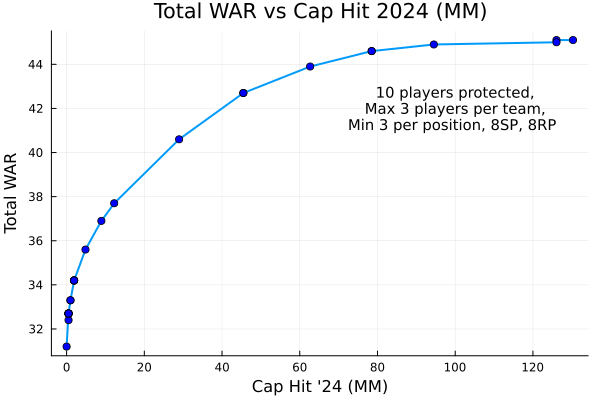

In [173]:
# Test financial flexibility

function run_simulation_for_alpha(alpha) 
    selected_players, clean_selected_players, term_status, protected_players_dict, total_war, caphit24 = simulation_basic(player_data, 10, 3, 3, 8, alpha) 
    result_df = DataFrame(alpha = alpha, total_war = total_war, caphit24 = caphit24)
    return result_df
end
 
alpha_values = [0, 0.000000005, 0.00000001, 0.000000015, 0.000000025, 0.000000035, 0.00000005, 0.000000075, 0.0000001, 0.00000015, 0.0000002, 0.0000003, 0.0000004, 0.0000005, 0.0000006, 0.0000007, 0.0000008, 0.0000009, 0.000001,  0.0000011,  0.0000012,  0.0000013,  0.0000014,  0.0000015,  0.0000016,  0.0000017,       0.000002, 0.001]
results_df = DataFrame(alpha = Float64[], total_war = Float64[], caphit24 = Float64[])
for alpha in alpha_values
    results_df = vcat(results_df, run_simulation_for_alpha(alpha))
end
println(results_df)

# Create a line chart
Plots.plot(  results_df.caphit24/1000000,  results_df.total_war, ylabel="Total WAR", xlabel="Cap Hit '24 (MM)", label="", title="Total WAR vs Cap Hit 2024 (MM)", linewidth=2)
annotation_text = "10 players protected,\nMax 3 players per team,\nMin 3 per position, 8SP, 8RP "
annotate!(100,42, Plots.text(annotation_text, :center, 10))
scatter!( results_df.caphit24/1000000,  results_df.total_war, label="", color=:blue)

9×2 DataFrame
 Row │ teamlim  total_war 
     │ Float64  Float64   
─────┼────────────────────
   1 │     2.0       41.3
   2 │     3.0       45.1
   3 │     4.0       46.5
   4 │     5.0       47.1
   5 │     6.0       47.3
   6 │     7.0       47.4
   7 │     8.0       47.4
   8 │     9.0       47.4
   9 │    10.0       47.4


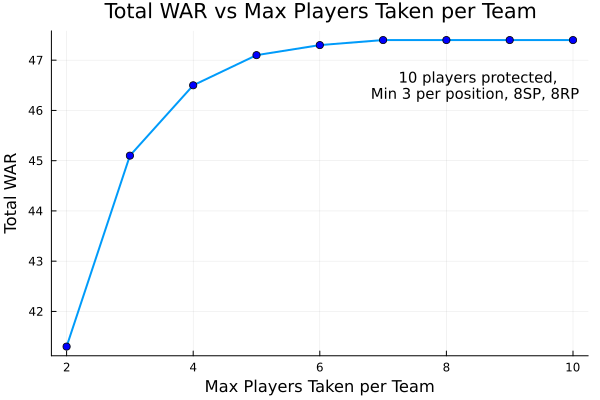

In [172]:
# Test team limits 

function run_simulation_for_teamlimit(teamlim) 
    selected_players, clean_selected_players, term_status, protected_players_dict, total_war, caphit24 = simulation_basic(player_data, 10, teamlim, 3, 8, 0) 
    result_df = DataFrame(teamlim = teamlim, total_war = total_war )
    return result_df
end
 
teamlim_values  = [2,3,4,5,6,7,8,9,10]
results_df = DataFrame(teamlim = Float64[], total_war = Float64[] )
for teamlim in teamlim_values
    results_df = vcat(results_df, run_simulation_for_teamlimit(teamlim))
end
println(results_df)

# Create a line chart
Plots.plot(  results_df.teamlim,  results_df.total_war, ylabel="Total WAR", xlabel="Max Players Taken per Team", label="", title="Total WAR vs Max Players Taken per Team", linewidth=2)
annotation_text = "10 players protected,\nMin 3 per position, 8SP, 8RP "
annotate!(8.5,46.5, Plots.text(annotation_text, :center, 10))
scatter!( results_df.teamlim,  results_df.total_war, label="", color=:blue)

4×2 DataFrame
 Row │ posmin   total_war 
     │ Float64  Float64   
─────┼────────────────────
   1 │     2.0       45.5
   2 │     3.0       45.1
   3 │     4.0       43.7
   4 │     5.0       41.3


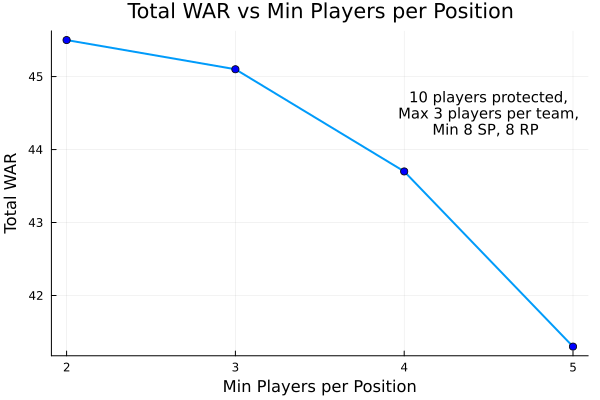

In [170]:
# Test position mins

function run_simulation_for_posmin(posmin) 
    selected_players, clean_selected_players, term_status, protected_players_dict, total_war, caphit24 = simulation_basic(player_data, 10, 3, posmin, 8, 0) 
    result_df = DataFrame(posmin = posmin, total_war = total_war )
    return result_df
end
 
posmin_values  = [2,3,4,5 ]
results_df = DataFrame(posmin = Float64[], total_war = Float64[] )
for posmin in posmin_values
    results_df = vcat(results_df, run_simulation_for_posmin(posmin))
end
println(results_df)

# Create a line chart
Plots.plot(  results_df.posmin,  results_df.total_war, ylabel="Total WAR", xlabel="Min Players per Position", label="", title="Total WAR vs Min Players per Position", linewidth=2)
annotation_text = "10 players protected,\nMax 3 players per team,\nMin 8 SP, 8 RP "
annotate!(4.5,44.5, Plots.text(annotation_text, :center, 10))
scatter!( results_df.posmin,  results_df.total_war, label="", color=:blue)

12×2 DataFrame
 Row │ pitchmin  total_war 
     │ Float64   Float64   
─────┼─────────────────────
   1 │      2.0       45.1
   2 │      3.0       45.1
   3 │      4.0       45.1
   4 │      5.0       45.1
   5 │      6.0       45.1
   6 │      7.0       45.1
   7 │      8.0       45.1
   8 │      9.0       45.0
   9 │     10.0       44.6
  10 │     11.0       43.9
  11 │     12.0       42.4
  12 │     13.0       39.6


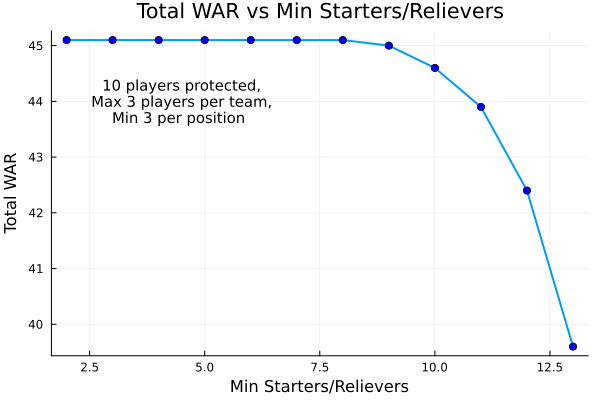

In [169]:
# Test pitcher mins 

function run_simulation_for_pitchmin(pitchmin) 
    selected_players, clean_selected_players, term_status, protected_players_dict, total_war, caphit24 = simulation_basic(player_data, 10, 3, 3, pitchmin, 0) 
    result_df = DataFrame(pitchmin = pitchmin, total_war = total_war )
    return result_df
end
 
pitchmin_values  = [2,3,4,5,6,7,8,9,10,11,12,13 ]
results_df = DataFrame(pitchmin = Float64[], total_war = Float64[] )
for pitchmin in pitchmin_values
    results_df = vcat(results_df, run_simulation_for_pitchmin(pitchmin))
end
println(results_df)

# Create a line chart
Plots.plot(  results_df.pitchmin,  results_df.total_war, ylabel="Total WAR", xlabel="Min Starters/Relievers", label="", title="Total WAR vs Min Starters/Relievers", linewidth=2)
annotation_text = "10 players protected,\nMax 3 players per team,\nMin 3 per position "
annotate!(4.5,44, Plots.text(annotation_text, :center, 10))
scatter!( results_df.pitchmin,  results_df.total_war, label="", color=:blue)

13×2 DataFrame
 Row │ protect  total_war 
     │ Float64  Float64   
─────┼────────────────────
   1 │     5.0       85.4
   2 │     6.0       74.7
   3 │     7.0       66.2
   4 │     8.0       58.8
   5 │     9.0       51.0
   6 │    10.0       45.1
   7 │    11.0       37.7
   8 │    12.0       31.2
   9 │    13.0       25.5
  10 │    14.0       19.7
  11 │    15.0       15.0
  12 │    16.0        9.7
  13 │    17.0        3.6


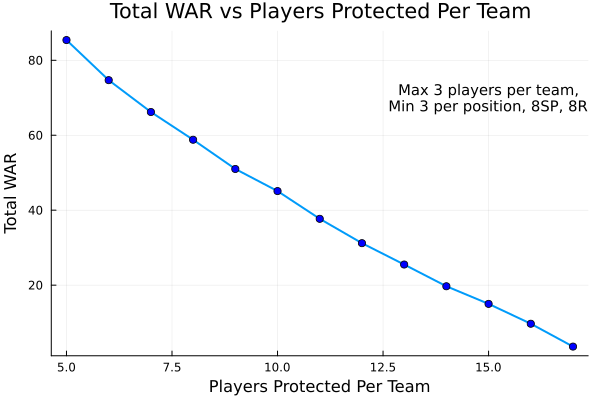

In [162]:
# Test num protected 

function run_simulation_for_protect(protect) 
    selected_players, clean_selected_players, term_status, protected_players_dict, total_war, caphit24 = simulation_basic(player_data, protect, 3, 3, 8, 0) 
    result_df = DataFrame(protect = protect, total_war = total_war )
    return result_df
end
 
protect_values  = [5,6,7,8,9,10,11,12,13,14,15,16,17 ]
results_df = DataFrame(protect = Float64[], total_war = Float64[] )
for protect in protect_values
    results_df = vcat(results_df, run_simulation_for_protect(protect))
end
println(results_df)

# Create a line chart
Plots.plot(  results_df.protect,  results_df.total_war, ylabel="Total WAR", xlabel="Players Protected Per Team", label="", title="Total WAR vs Players Protected Per Team", linewidth=2)
annotation_text = "Max 3 players per team,\nMin 3 per position, 8SP, 8RP"
annotate!(15,70, Plots.text(annotation_text, :center, 10))
scatter!( results_df.protect,  results_df.total_war, label="", color=:blue) 

## Rounds

- Each round, teams are able to protect 3 more players
- Then the expansion team is able to take 1 player
- We can have a column that determines whether or not the player can be selected.

### Constraints
**Salary Cap (Selection Models):**
$$ \sum_{i \in I} y_{i} \cdot Salary_{i} \leq SalaryCap $$

**Player Protection (Existing Teams):**
$$ \sum_{i \in I} x_{ij} \leq 15, \forall j \in J $$

**Player Position (Selection and Protection):**
$$ PositionMin_{p} \leq \sum_{i \in P} x_{ij} \leq PositionMax_{p}, \forall p \in Positions $$

**Player Drafting (Expansion):**
$$ \sum_{i \in I} y_{i} = 35 $$

**Player Affiliation (One Player per MLB Team):**
$$ \sum_{i \in I_{j}} y_{i} \leq 1, \forall j \in J $$

- $I$: Set of draft-eligible MLB players.
- $I_{j}$: Set of players available for drafting from MLB team $j$.
- $J$: Set of existing MLB teams.
- $P$: Set of eligible position pools.
- $WAR_{i}$: Wins Above Replacement value for player $i$.
- $Salary_{i}$: Annual salary of player $i$.
- $SalaryCap$: Total salary cap for the expansion team.
- $PositionMin_{p}, PositionMax_{p}$: Minimum and maximum number of players to be held at position $p$.

In [181]:
player_data2 = CSV.read("OptimizationProject/Data/player_data.csv", DataFrames.DataFrame, delim = ",", header = true)
player_data = player_data2

selected_IDs = Vector{Any}()
rounds_data = player_data 

function simulation_rounds(player_data, protect_tuple, teamlim, posmin, pitchmin, alpha, rounds, picks_tuple )  
    
    total_salary = 0 
    
    teams_list = unique(player_data.shortName)

    function protection_model(war,data, protect)
        model = JuMP.Model(GLPK.Optimizer)

        @variable(model, x[1:length(war)], Bin)
        (((x, label),) -> set_name(x,label)).(zip(x,String.(data[!,9])))
    
        @constraint(model, sum(x[1:length(war)]) == protect)

        @objective(model, Max, war'x[1:length(war)])

        optimize!(model)
        return model, x
    end

    protected_players_df = DataFrame()
    protected_players_dict = Dict{String, DataFrame}() 

    for round in 1:rounds

        picks = picks_tuple[round]
        protect = protect_tuple[round]
        print(round, "\n")

        protected_players_dict = Dict{String, DataFrame}() 

        unprotected_players_df = DataFrame()

        ## PROTECTION FUNCTION
        # Each team chooses a list of players that they want to protect 

        function apply_protection(data)
            # Iterate over each team in teams_list
            for team in teams_list
                # Filter protectable players for the current team
                protectable_team_players = filter(row -> row.Selectable == 1 && row.shortName == team, data)
                WAR = protectable_team_players[!,"WAR"]

                # Apply protection model to select top x players by WAR
                model, x = protection_model(WAR, protectable_team_players, protect)
                optimize!(model)
                
                # Check if optimization was successful
                if termination_status(model) == MOI.OPTIMAL || termination_status(model) == MOI.LOCALLY_SOLVED
                    protected_players_indices = findall(value.(JuMP.value.(x)) .== 1) 
                    protected_key_bbref_values = protectable_team_players[protected_players_indices, :][:, :key_bbref]
                    # Update the Selectable column in data dataframe where key_bbref matches
                    for key_bbref in protected_key_bbref_values
                        data[data.key_bbref .== key_bbref, :Selectable] .= 0
                    end

                    non_selectable_team_players = filter(row -> row.Selectable == 0 && row.shortName == team, data)
                    protected_players_dict[team] = non_selectable_team_players
 
                    # Filter out unprotected players for the current team
                    unprotected_players = filter(row -> row.Selectable == 1 && row.shortName == team, data)

                    # Append              
                    append!(unprotected_players_df, unprotected_players)
                    
                else
                    # Team has fewer than x players to protect 
                    println("No more players to protect for $team")

                    protected_players = protectable_team_players  
                    non_selectable_team_players = filter(row -> row.Selectable == 0 && row.shortName == team, data)
                    # Combine protected and non-protectable players into a single DataFrame
                    team_players_df = vcat(protected_players, non_selectable_team_players)
                    protected_players_dict[team] = team_players_df
                end 
            end
        end
        
        apply_protection(player_data)

        ## SELECTION FUNCTION
        function selection_model(dataframe, picks)

            salary = dataframe[:,"2023"]
            WAR_remaining = dataframe[:,"WAR"]
            future_salary = dataframe[:,"2024Est"] 

            model = JuMP.Model(GLPK.Optimizer)

            @variable(model, x[1:length(WAR_remaining)], Bin) # Whether the player was chosen or not

            (((x, label),) -> set_name(x,label)).(zip(x,String.(dataframe[!,9])))

            @constraint(model, sum(x[1:length(WAR_remaining)]) .== picks) # Round amount
            @constraint(model, sum(salary .* x[1:length(salary)]) .+ total_salary .<= 223000000) # Making sure it doesn't go over the salary cap of 223 Million

             # Making sure there is at least one player taken from each team 
            for col in 31:60
                @constraint(model, sum(dataframe[!, col] .* x) .<= teamlim)
            end  

            # Making sure there is at least two players per position
            for col in 20:27
                @constraint(model, sum(dataframe[!, col] .* x) .>= posmin)
            end     

            # Making sure there are enough pitchers
            for col in 28:29
                @constraint(model, sum(dataframe[!, col] .* x) .>= pitchmin)
            end         
        
            @objective(model, Max, dot(WAR_remaining, x[1:length(WAR_remaining)])   - alpha  *   dot(future_salary, x[1:length(WAR_remaining)]))
            
            optimize!(model) 
            return model, x
        end


        selection_model2, x = selection_model(unprotected_players_df, picks)
        term_status = JuMP.termination_status(selection_model2) 
        selected_players_indices = findall(value.(JuMP.value.(x)) .== 1) 
        selected_players = unprotected_players_df[selected_players_indices, :] 
        total_salary = sum(selected_players[!,"2023"]) 

        selected_key_bbref_values = unprotected_players_df[selected_players_indices, :][:, :key_bbref]
        # Update the Selectable column in data dataframe where key_bbref matches and store all selected IDs 
        for key_bbref in selected_key_bbref_values
            player_data[player_data.key_bbref .== key_bbref, :Selectable] .= 0
            push!(selected_IDs, key_bbref)
        end

        total_salary = sum(selected_players[!,"2023"])
        total_war = sum(selected_players.WAR)
        caphit24 = sum(selected_players[!, "2024Est"])
        clean_selected_players = select(selected_players, [:Name, :WAR,  :shortName, :Position_c,	:Position_1b,	:Position_2b,	:Position_3b,	:Position_ss,	:Position_lf,	:Position_cf,	:Position_rf,	 :Position_Starter,	:Position_Reliever])
    end
    
    selected_players = filter(row -> row.key_bbref in selected_IDs, player_data) 
    total_salary = sum(selected_players[!,"2023"])
    total_war = sum(selected_players.WAR)
    caphit24 = sum(selected_players[!, "2024Est"])
    clean_selected_players = select(selected_players, [:Name, :WAR,  :shortName, :SimplePosition])
    return selected_players, clean_selected_players,   protected_players_dict,  total_war, caphit24
end

simulation_rounds (generic function with 2 methods)

In [182]:
mod3 = simulation_rounds(rounds_data, (10,3,3), 1, 0, 1, 0, 3, (14,14,7) )  

1


2
No more players to protect for Oakland


No more players to protect for Detroit
3
No more players to protect for Houston
No more players to protect for Cleveland
No more players to protect for Baltimore
No more players to protect for Minnesota
No more players to protect for Arizona
No more players to protect for Pittsburgh
No more players to protect for Kansas City


No more players to protect for Oakland
No more players to protect for Detroit
No more players to protect for Cincinnati


(35×60 DataFrame
 Row │ IDfg   Name                Age    G      AB     WAR      name_last      ⋯
     │ Int64  String31            Int64  Int64  Int64  Float64  String15       ⋯
─────┼──────────────────────────────────────────────────────────────────────────
   1 │ 14813  Kyle Farmer            30    145    526      1.5  farmer         ⋯
   2 │ 16512  Isiah Kiner-Falefa     26    142    483      1.5  kiner-falefa
   3 │  8202  Josh Harrison          33    119    386      1.4  harrison
   4 │ 19252  Cavan Biggio           26     97    257      1.4  biggio
   5 │ 16556  Ozzie Albies           24     64    247      1.2  albies         ⋯
   6 │ 13338  Omar Narvaez           29     84    262      1.1  narváez
   7 │  6184  J.D. Martinez          33    139    533      1.0  martinez
   8 │ 18889  Danny Mendick          27     31     97      0.8  mendick
  ⋮  │   ⋮            ⋮             ⋮      ⋮      ⋮       ⋮          ⋮         ⋱
  29 │ 17859  Adbert Alzolay         26      6      0      

In [183]:
mod3[2]

Row,Name,WAR,shortName,SimplePosition
,String31,Float64,String15,String31?
1,Kyle Farmer,1.5,Minnesota,"3b,ss"
2,Isiah Kiner-Falefa,1.5,NY Yankees,"3b,ss"
3,Josh Harrison,1.4,Philadelphia,"2b,3b"
4,Cavan Biggio,1.4,Toronto,"1b,2b,rf"
5,Ozzie Albies,1.2,Atlanta,2b
6,Omar Narvaez,1.1,NY Mets,c
7,J.D. Martinez,1.0,LA Dodgers,missing
8,Danny Mendick,0.8,NY Mets,"2b,ss"
9,David Fletcher,0.7,LA Angels,"2b,ss"


In [184]:
mod3[4]

31.900000000000002

In [185]:
mod3[5]

1.04959e8